In [52]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from scipy.stats import binned_statistic_2d
from utils.binning_utils import find_nearest_idx
from utils.hdf_utils import load_measurement_data_devices_attrs

In [153]:
def integrate_data_loc(fname, dset_name, pmt_channel, pd_channel, pdn_channel):
    
    mask_abs = np.s_[:750]
    mask_flu = np.s_[100:]
    
    devices = ('ZaberTMM',)

    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)
        
    # find nearest entry for mirror coordinates corresponding to YAG firing
    idx_pairs = {idx_pxie: find_nearest_idx(data_devices['ZaberTMM']['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
    sorted_pxie_indices = np.array(list(idx_pairs.keys()))
    sorted_pxie_indices.sort()
    
    pxie_indices = np.array(list(idx_pairs.keys()))
    zaber_indices = np.array(list(idx_pairs.values()))


    indices_sort = np.argsort(pxie_indices)
    pxie_indices = pxie_indices[indices_sort]
    zaber_indices = zaber_indices[indices_sort]

    n = pxie[1].shape[0]

    t = np.arange(0,n,1)/100

    pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in pxie_indices])
    pd_data = -np.array([pxie[idx][:,pd_channel].astype(float) for idx in pxie_indices])
    pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in pxie_indices])
    pmt_data -= pmt_data[:,50:200].mean(axis = 1)[:,np.newaxis]
        
    integrals_pmt = np.trapz(pmt_data[:,mask_flu], axis = 1)
    norm = pd_data/pdn_data
    norm -= norm[:,-750:].mean(axis = 1)[:,np.newaxis]
    integrals_normalized = np.trapz(norm[:,mask_abs], axis = 1)
    target_loc = [*zip(d[-1]['ZaberTMM']['x'][zaber_indices], d[-1]['ZaberTMM']['y'][zaber_indices])]        
    
    return target_loc, integrals_pmt, integrals_normalized, pmt_data, norm

In [154]:
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

In [155]:
fnames = {'2021_1_28': ["1611873822 check correlation absorption and fluorescence"],
          '2021_1_27': ["1611788741 absorption correlation check"],
#           '2021_1_26': [
#                         "1611708260 correlation check",
#                         "1611708511 correlation check",
#                         "1611709697 correlation check",
#                         "1611710690 correlation check moved absorption beam",
#                         "1611710850 correlation check moved absorption beam 10 kHz PD lowpass"
#                         ]
         }

In [156]:
locations = []
fluorescence_signals = []
absorption_signals = []
traces_fl = []
traces_ab = []
for fname, dset_names in fnames.items():
    for dset_name in dset_names:
        print(fname, dset_name)
        loc, fl, ab, tr_fl, tr_ab= integrate_data_loc(fname+'.hdf', dset_name, pmt_channel, pd_channel, pdn_channel)
        locations.extend(loc)
        fluorescence_signals.extend(fl.tolist())
        absorption_signals.extend(ab.tolist())
        traces_fl.extend(tr_fl.tolist())
        traces_ab.extend(tr_ab.tolist())
        
traces_fl = np.asarray(traces_fl)
traces_ab = np.asarray(traces_ab)

2021_1_28 1611873822 check correlation absorption and fluorescence
2021_1_27 1611788741 absorption correlation check


In [218]:
y_mirror, x_mirror = zip(*locations)

## Fluorescence

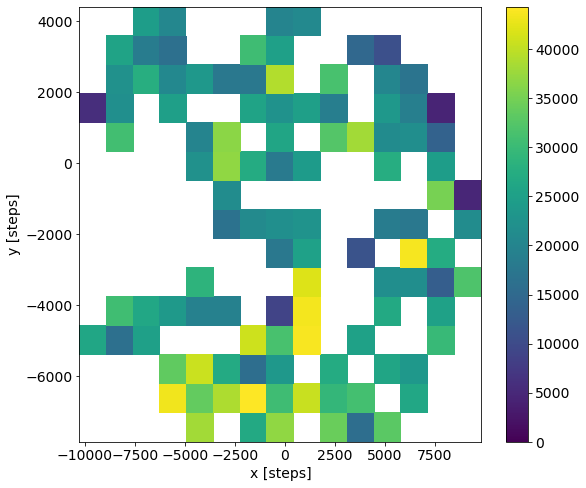

In [219]:
stat, x_edge, y_edge, _ = binned_statistic_2d(x_mirror, y_mirror, fluorescence_signals, lambda x: np.nanmean(x), bins = 15, 
                                              expand_binnumbers = True)

x_bin_width = np.diff(x_edge)[0]
y_bin_width = np.diff(y_edge)[0]
X, Y = np.meshgrid(x_edge,y_edge)

fig, ax = plt.subplots(figsize = (9,8))
cs = ax.pcolormesh(X,Y,stat, vmin = 0)
# ax.contour(X[:-1,:-1]+x_bin_width/2,Y[:-1,:-1]+y_bin_width/2,stat, levels = [2e4,3e4], colors = 'k')

cbar = fig.colorbar(cs)

ax.set_xlabel('x [steps]')
ax.set_ylabel('y [steps]')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [220]:
counter = np.zeros([15,15])
traces_binned = np.zeros([15,15,2000])
for (idx, idy), trace in zip(_.T, traces_fl):
    traces_binned[idx-1,idy-1] += trace
    counter[idx-1,idy-1] += 1
traces_binned /= counter[:,:,np.newaxis]
    
traces_binned -= np.mean(traces_binned[:,:,:250], axis = 2)[:,:,np.newaxis]

<ipython-input-220-ed5a5a851338>:6: RuntimeWarning: invalid value encountered in true_divide
  traces_binned /= counter[:,:,np.newaxis]


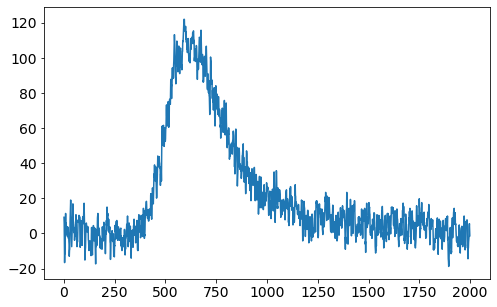

In [212]:
idx = np.unravel_index(np.nanargmax(stat), stat.shape)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(traces_binned[idx])

set_fontsize(ax, 14)

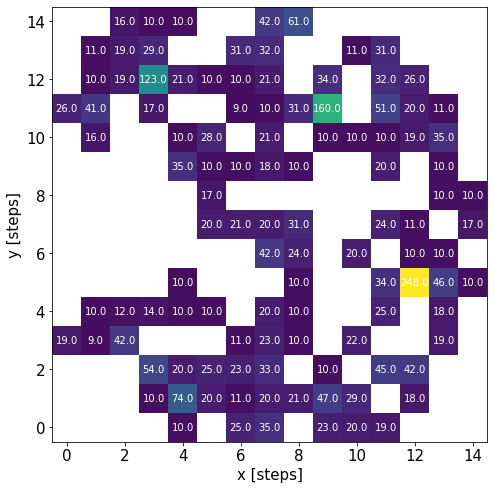

In [228]:
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(counter, vmin = 1, origin = 'lower')

for idx in range(15):
    for idy in range(15):
        text = ax.text(idy, idx, counter[idx, idy],
                       ha="center", va="center", color="w")

ax.set_xlabel('x [steps]')
ax.set_ylabel('y [steps]')

set_fontsize(ax, 15)

## Absorption

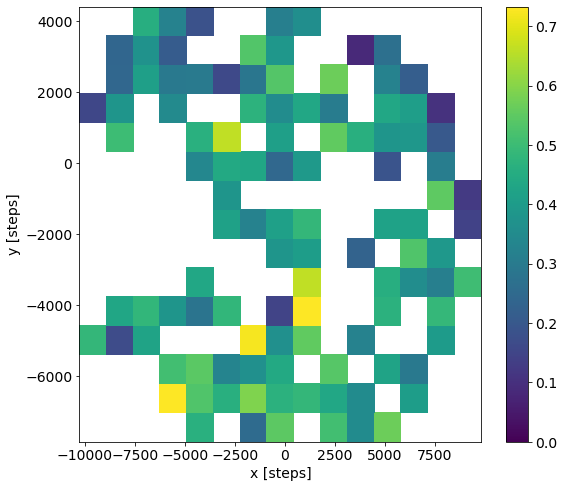

In [161]:
stat, x_edge, y_edge, _ = binned_statistic_2d(x_mirror, y_mirror, absorption_signals, lambda x: np.nanmean(x), bins = 15, 
                                              expand_binnumbers = True)

x_bin_width = np.diff(x_edge)[0]
y_bin_width = np.diff(y_edge)[0]
X, Y = np.meshgrid(x_edge,y_edge)

fig, ax = plt.subplots(figsize = (9,8))
cs = ax.pcolormesh(X,Y,stat, vmin = 0)
# ax.contour(X[:-1,:-1]+x_bin_width/2,Y[:-1,:-1]+y_bin_width/2,stat, levels = 5, colors = 'k')

cbar = fig.colorbar(cs)

ax.set_xlabel('x [steps]')
ax.set_ylabel('y [steps]')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [164]:
counter = np.zeros([15,15])
traces_binned = np.zeros([15,15,2000])
for (idx, idy), trace in zip(_.T, traces_ab):
    traces_binned[idx-1,idy-1] += trace
    counter[idx-1,idy-1] += 1
traces_binned /= counter[:,:,np.newaxis]
    
traces_binned -= np.mean(traces_binned[:,:,-750:], axis = 2)[:,:,np.newaxis]

<ipython-input-164-9457316bf96c>:6: RuntimeWarning: invalid value encountered in true_divide
  traces_binned /= counter[:,:,np.newaxis]


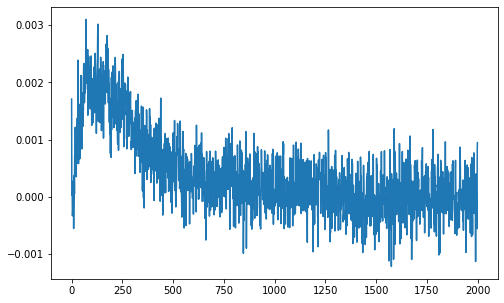

In [165]:
idx = np.unravel_index(np.nanargmax(stat), stat.shape)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(traces_binned[idx])